# Reservoir curves - US
***

In [8]:
import numpy as np
import pandas as pd
import geopandas as gpd

from pathlib import Path
from datetime import datetime
#from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from lisfloodreservoirs import read_attributes, read_timeseries
from lisfloodreservoirs.utils.reservoir_curves import bin_data, fit_reservoir_curve, storage_from_elevation, area_from_elevation

## Config

In [5]:
country = 'US'
long_name = 'United States'
extent = [-125, 24, -66, 50]

path_datasets = Path('/home/chus-casado/Datos')

## Data

### Global Dam Watch

In [6]:
path_gdw = path_datasets / 'reservoirs' / 'GDW' / 'GDW_v1_0_shp'
gdw = gpd.read_file(path_gdw / 'GDW_barriers_v1_0.shp').set_index('GRAND_ID')
gdw = gdw[gdw.COUNTRY == long_name]
print(f'GDW contains {len(gdw)} reservoirs in {long_name}')

GDW contains 4862 reservoirs in United States


### ResOpsUS

In [7]:
path_resops = path_datasets / 'reservoirs' / 'ResOpsUS' / 'v2.2'

# list of selected reservoirs
res_list = pd.read_csv(path_resops / 'selection' / 'reservoirs.txt', header=None).squeeze().tolist()

# load reservoir attributes
resops_attrs = read_attributes(
    path=path_resops / 'attributes',
    reservoirs=res_list,
    index_col='GRAND_ID'
)

# load time series
resops_ts = read_timeseries(
    path=path_resops / 'time_series' / 'csv',
    reservoirs=resops_attrs.index,
)
for grand_id, df in resops_ts.items():
    if 'storage' in df.columns:
        df.storage *= 1e-6 # convert to hm3
    df = df[df.columns.intersection(['inflow', 'outflow', 'storage', 'elevation'])]
    resops_ts[grand_id] = df

# reduce reservoirs to those in both GDW and ResOps datasets
grand_ids = gdw.index.intersection(resops_ts.keys())
gdw = gdw.loc[grand_ids]
resops_ts = {grand_id: resops_ts[grand_id] for grand_id in grand_ids}
print(f'{len(grand_ids)} are both in GDW and ResOps datasets')

  0%|          | 0/164 [00:00<?, ?it/s]

164 are both in GDW and ResOps datasets


## Reservoir curves

##### Fit reservoir curves

In [18]:
grand_id = 355

# attributes
dam_hgt_m, elev_masl, cap_mcm, area_skm = gdw.loc[grand_id, ['DAM_HGT_M', 'ELEV_MASL', 'CAP_MCM', 'AREA_SKM']]

# observed time series
obs = resops_ts[grand_id].copy()

# this reservoir has different curves in time
start = datetime(2011, 6, 1)

z_values = np.linspace(elev_masl - dam_hgt_m, elev_masl + .1, 100)
a_values = np.linspace(0, area_skm, 100)

In [22]:
# extract data 
obs = resops_ts[grand_id].loc[start:].copy()
obs['area'] = obs.storage.diff() / obs.elevation.diff()

# compute bin medians
train_data = bin_data(obs.elevation, obs[['storage', 'area']], bin_size=1)

# add maximum and minimum capacity
train_data.loc[elev_masl, ['storage', 'area']] = cap_mcm, area_skm
train_data.loc[elev_masl - dam_hgt_m] = 0
train_data.sort_index(inplace=True)
train_data.reset_index(drop=False, inplace=True)

In [ ]:
# fit reservoir curves
zv_curve = fit_reservoir_curve(
    train_data.elevation,
    train_data.storage,
    method='pchip'
)
za_curve = fit_reservoir_curve(
    train_data.elevation,
    train_data.area,
    method='pchip'
)
av_curve = fit_reservoir_curve(
    train_data.area,
    train_data.storage,
    method='pchip'
)

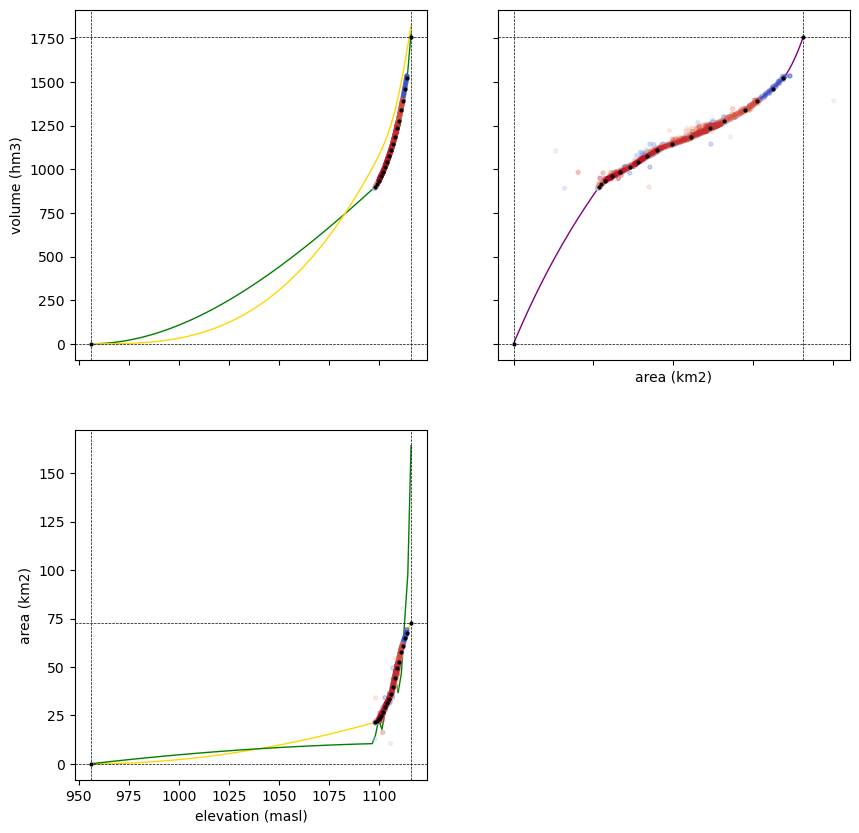

In [30]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10), sharex='col', sharey='row')

var_props = {
    'elevation': {
        'label': 'elevation (masl)',
        'ref': [elev_masl - dam_hgt_m, elev_masl] 
    },
    'area': {
        'label': 'area (km2)',
        'ref': [0, area_skm]
    },
    'storage': {
        'label': 'volume (hm3)',
        'ref': [0, cap_mcm]
    }
}

aux_props = dict(ls='--', lw=.5, c='k', zorder=0)
zv_props = dict(lw=1, c='green', zorder=0)
za_props = dict(lw=1, c='gold', zorder=0)
av_props = dict(lw=1, c='purple', zorder=0)

for j, var_x in enumerate(['elevation', 'area']):
    for i, var_y in enumerate(['storage', 'area']):
        
        ax = axes[i,j]
        if i == 1 & j == 1:
            ax.axis('off')
            continue
        ax.scatter(
            obs[var_x], 
            obs[var_y], 
            c=obs.index, 
            cmap='coolwarm',
            s=8,
            alpha=.3
        )
        ax.scatter(
            train_data[var_x], 
            train_data[var_y], 
            c='k', 
            s=4
        )
        if var_x == 'elevation':
            if var_y == 'storage':
                ax.plot(z_values, zv_curve(z_values), **zv_props)
                ax.plot(z_values, za_curve.antiderivative()(z_values), **za_props)
            if var_y == 'area':
                ax.plot(z_values, za_curve(z_values), **za_props)
                ax.plot(z_values, zv_curve.derivative()(z_values), **zv_props)
        elif var_x == 'area':
            if var_y == 'storage':
                ax.plot(a_values, av_curve(a_values), **av_props)
            
        for x in var_props[var_x]['ref']:
            ax.axvline(x, **aux_props)
        for y in var_props[var_y]['ref']:
            ax.axhline(y, **aux_props)

        if (i == 1) | (j == 1):
            ax.set_xlabel(var_props[var_x]['label'])
        if j == 0:
            ax.set_ylabel(var_props[var_y]['label'])